In [1]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *

sys.path.insert(0, '../param_est/')
from sampling_utils import *

rng = np.random.default_rng(seed=1234)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we write a function to load in SMC idata... If the chains run for different numbers of stages than the sample_stats lists have different shapes which makes np.array mad. We leave this as a dict of lists for now

In [2]:
def load_smc_samples_to_idata(samples_json):
    """ Load SMC samples from json file to arviz InferenceData object """
    with open(samples_json, 'r') as f:
        data = json.load(f)
    
    # create idata object from dictionary
    # ignore sample stats because that changes with each SMC chain
    idata = az.from_dict(
        posterior =  data['posterior'],
        posterior_attrs = data['posterior_attrs'],
        # sample_stats = data['sample_stats'],
        observed_data = data['observed_data'],
        observed_data_attrs = data['observed_data_attrs'],
        log_likelihood = data['log_likelihood'],
        log_likelihood_attrs = data['log_likelihood_attrs'],
        constant_data = data['constant_data'],
        constant_data_attrs = data['constant_data_attrs'],
        attrs = data['attrs'],
    )

    sample_stats = data['sample_stats']

    return idata, sample_stats

Now load in all of the posterior idata and the posterior predictive samples...

In [40]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
# H_2005_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/hornberg_2005_smc_samples.json') # TODO: add once smc is done
# H_2005_post = np.load('../../../results/MAPK/param_est/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
K_2017_post = np.load('../../../results/MAPK/param_est/kochanczyk_2017_posterior_predictive_samples.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood'][0]])
HK_2003_log_magr = np.mean([chain[-1] for chain in HK_2003_ss['log_marginal_likelihood']])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood'][0]])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood']])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood']])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])
B_2007_log_magr = np.mean([chain[-1] for chain in B_2007_ss['log_marginal_likelihood'][0]])

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','birtwistle_2007','orton_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Birtwistle 2007','Orton 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']
log_marginal_likes = np.array([K_2000_log_magr, L_2000_log_magr, HK_2003_log_magr,B_2007_log_magr, O_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])

# Birtwistle 2007 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
B_2007_posts = [B_2007_post for _ in range(10)]
B_2007_post = np.vstack(B_2007_posts)
B_2007_post = B_2007_post[rng.permutation(np.arange(4000))]

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, B_2007_post, O_2009_post, S_2014_post, R_2015_post, K_2017_post]
shin_id = 5
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# create dict of idata
dict_compare = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hatakeyama_2003': HK_2003_idata, 'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017': K_2017_idata}

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+3)

# sns.color_palette("husl", len(model_names)+2)

Now run arviz model comparison get eldpd_loo for each model and save to a dict

In [41]:
compare_data_waic_pbma = az.compare(dict_compare, ic='waic', method='BB-pseudo-BMA')
compare_data_loo_pbma = az.compare(dict_compare, ic='loo', method='BB-pseudo-BMA')
compare_data_waic_stack = az.compare(dict_compare, ic='waic', method='stacking')
compare_data_loo_stack = az.compare(dict_compare, ic='loo', method='stacking')

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/sit

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/874285800.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/874285800.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)


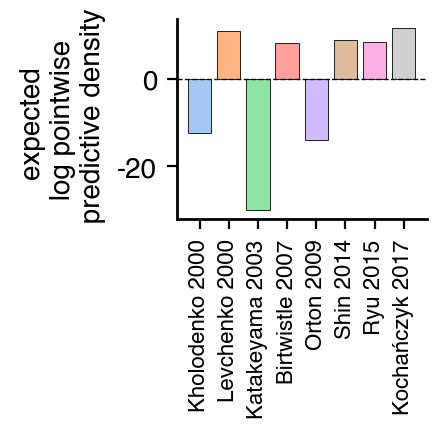

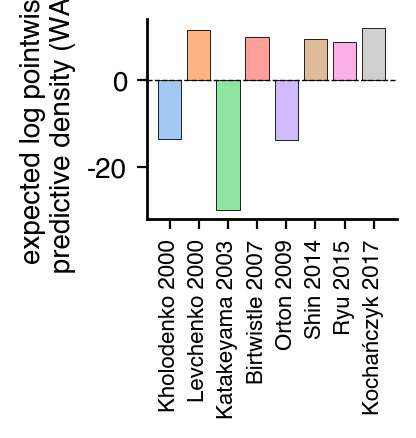

In [42]:
# make a plot of elpd_loo, and elpd_waic
dat = [compare_data_loo_stack.loc[model]['elpd_loo'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 1.)
bar = ax.bar(model_names, dat, edgecolor='k')
ax.set_ylabel('expected \n log pointwise \n predictive density', fontsize=10)
ax.set_yticks([-20, 0])
ax.set_yticklabels([-20, 0], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
fig.savefig('../../../results/MAPK/mmi/mapk_elpd_loo.pdf', transparent=True)

# waic
dat = [compare_data_waic_stack.loc[model]['elpd_waic'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 1.)
bar = ax.bar(model_names, dat, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('expected log pointwise \n predictive density (WAIC)', fontsize=10)
ax.set_yticks([-20, 0])
ax.set_yticklabels([-20, 0], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
fig.savefig('../../../results/MAPK/mmi/mapk_elpd_waic.pdf', transparent=True)

Bayesian model averaging - plot bar plot of model probabilities

[-10.55782407   5.02413276 -31.43088824   5.33193453 -28.36095985
   7.68601559   6.40375142   7.58190537]


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/1473629885.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)


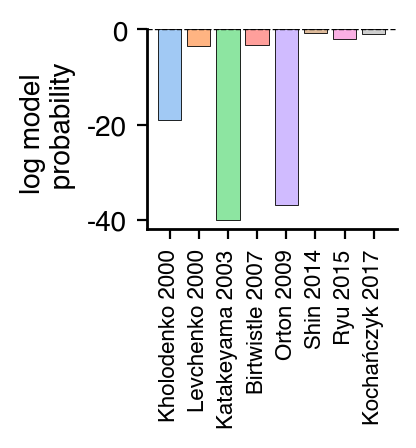

In [43]:
n_models = len(log_marginal_likes)
prior_prob = 1/n_models

normalizing_constant = np.sum(prior_prob*np.exp(log_marginal_likes))
model_probs = prior_prob*np.exp(log_marginal_likes)/normalizing_constant
print(log_marginal_likes)
fig, ax = get_sized_fig_ax(1.25, 1.)
bar = ax.bar(model_names, np.log(model_probs), edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('log model \n probability', fontsize=10)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_yticks([0, -20, -40])
ax.set_yticklabels([0, -20, -40], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/mapk_model_prob.pdf', transparent=True)

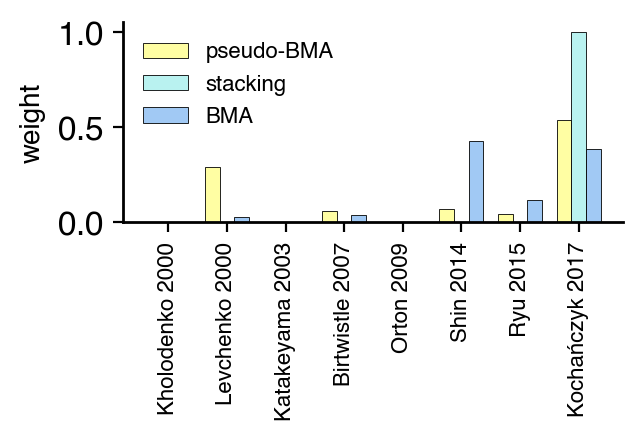

In [44]:



x = np.arange(n_models)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack.loc[model]['weight'] for model in model_names]
pBMA = [compare_data_loo_pbma.loc[model]['weight'] for model in model_names]


fig, ax = get_sized_fig_ax(2.5, 1.)
for dat, name, col in zip([pBMA, stack,model_probs], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k')
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=10)
ax.set_xticks(x + width, display_names)
ax.legend(loc='upper left', fontsize=8.0)

ax.set_ylabel(r'weight', fontsize=10)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/mapk_model_weights.pdf', transparent=True)

Generate predictive samples from the averaged predictive density

In [45]:
loo_pbma_combined = np.zeros_like(posterior_samples[0])
loo_stack_combined = np.zeros_like(posterior_samples[0])
loo_bma_combined = np.zeros_like(posterior_samples[0])
for i, name in enumerate(model_names):
    loo_pbma_combined += compare_data_loo_pbma.loc[name]['weight']*posterior_samples[i]
    loo_stack_combined += compare_data_loo_stack.loc[name]['weight']*posterior_samples[i]
    loo_bma_combined += model_probs[i]*posterior_samples[i]

In [46]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = plt_func.get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/4173960011.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)


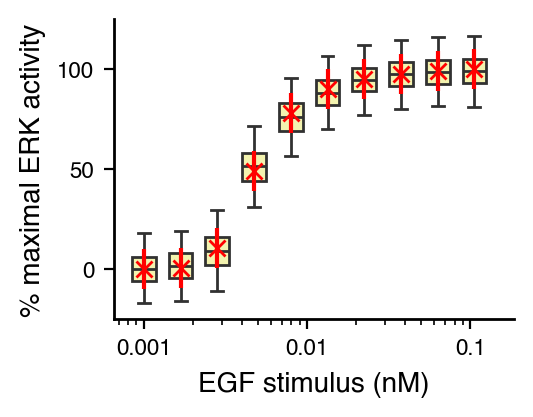

In [47]:
fig, ax = plot_stimulus_response_curve(loo_pbma_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-3], data_color='r',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
# ax.plot(inputs, np.mean(K_2000_post, axis=0), '.', color=colors[0], markeredgewidth=0.5, zorder=10, label='Kholodenko 2000', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(L_2000_post, axis=0), '.', color=colors[1], markeredgewidth=0.5, zorder=10, label='Levchenko 2000', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(HK_2003_post, axis=0), '.', color=colors[2], markeredgewidth=0.5, zorder=10, label='Hatakeyama 2003', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(O_2009_post, axis=0), '.', color=colors[3], markeredgewidth=0.5, zorder=10, label='Orton 2009', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(S_2014_post, axis=0), '.', color=colors[4], markeredgewidth=0.5, zorder=10, label='Shin 2014', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(R_2015_post, axis=0), '.', color=colors[5], markeredgewidth=0.5, zorder=10, label='Ryu 2015', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(K_2017_post, axis=0), '.', color=colors[6], markeredgewidth=0.5, zorder=10, label='Kochańczyk 2017', markersize=9, markeredgecolor='k')
# ax.set_title('pseudo Bayesian Model Averaging (ELPD LOO-CV)')
leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/mapk_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)

fig.savefig('../../../results/MAPK/mmi/mapk_pbma_avg.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/540673362.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)


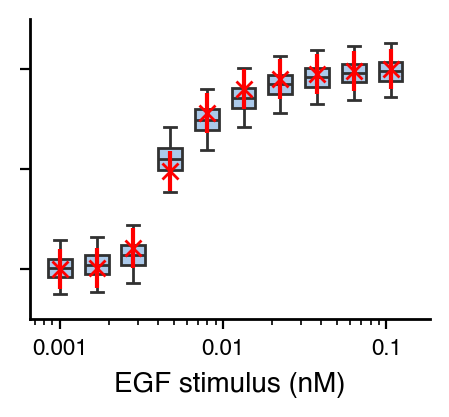

In [48]:
fig, ax = plot_stimulus_response_curve(loo_bma_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1], data_color='r',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
# ax.plot(inputs, np.mean(K_2000_post, axis=0), '.', color=colors[0], markeredgewidth=0.5, zorder=10, label='Kholodenko 2000', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(L_2000_post, axis=0), '.', color=colors[1], markeredgewidth=0.5, zorder=10, label='Levchenko 2000', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(HK_2003_post, axis=0), '.', color=colors[2], markeredgewidth=0.5, zorder=10, label='Hatakeyama 2003', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(O_2009_post, axis=0), '.', color=colors[3], markeredgewidth=0.5, zorder=10, label='Orton 2009', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(S_2014_post, axis=0), '.', color=colors[4], markeredgewidth=0.5, zorder=10, label='Shin 2014', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(R_2015_post, axis=0), '.', color=colors[5], markeredgewidth=0.5, zorder=10, label='Ryu 2015', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(K_2017_post, axis=0), '.', color=colors[6], markeredgewidth=0.5, zorder=10, label='Kochańczyk 2017', markersize=9, markeredgecolor='k')
# ax.set_title('Bayesian Model Averaging')
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/mapk_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/mapk_bma_avg.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/2732204824.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)


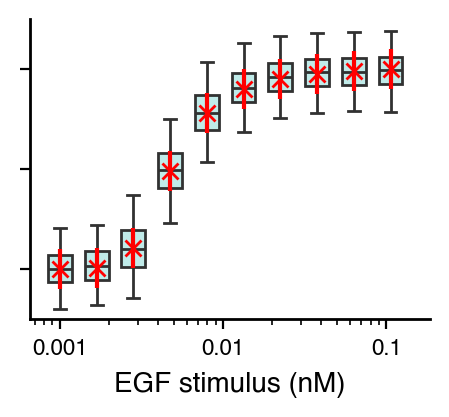

In [49]:
fig, ax = plot_stimulus_response_curve(loo_stack_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2], data_color='r',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
# ax.plot(inputs, np.mean(K_2000_post, axis=0), '.', color=colors[0], markeredgewidth=0.5, zorder=10, label='Kholodenko 2000', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(L_2000_post, axis=0), '.', color=colors[1], markeredgewidth=0.5, zorder=10, label='Levchenko 2000', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(HK_2003_post, axis=0), '.', color=colors[2], markeredgewidth=0.5, zorder=10, label='Hatakeyama 2003', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(O_2009_post, axis=0), '.', color=colors[3], markeredgewidth=0.5, zorder=10, label='Orton 2009', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(S_2014_post, axis=0), '.', color=colors[4], markeredgewidth=0.5, zorder=10, label='Shin 2014', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(R_2015_post, axis=0), '.', color=colors[5], markeredgewidth=0.5, zorder=10, label='Ryu 2015', markersize=9, markeredgecolor='k')
# ax.plot(inputs, np.mean(K_2017_post, axis=0), '.', color=colors[6], markeredgewidth=0.5, zorder=10, label='Kochańczyk 2017', markersize=9, markeredgecolor='k')
# ax.set_title('Bayesian Model Averaging')
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/mapk_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticklabels(ax.get_xticks(), fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/mapk_stack_avg.pdf', transparent=True)

Now compute RMSE for each model. Will do this for each model averaged predictive sample then make a bar plot with error bars

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/2935462379.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)


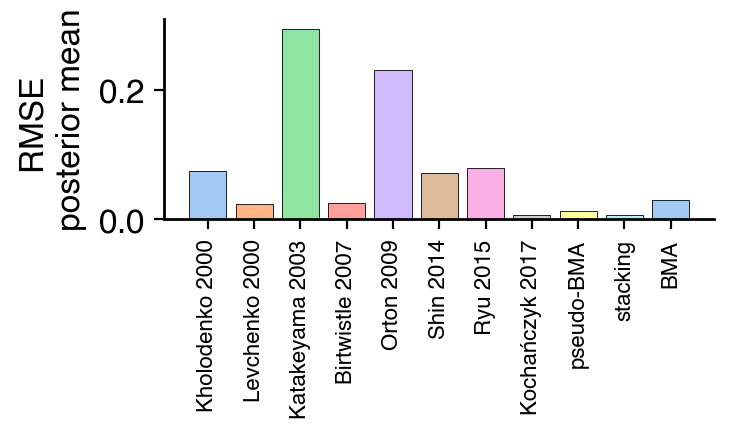

In [50]:
RMSE_samples = []
for i, name in enumerate(model_names):
    RMSE_samples.append(np.sqrt(np.mean((np.mean(posterior_samples[i], axis=0) - data.T)**2)))

# add RMSE for BMA and pseudo-BMA
RMSE_samples.append(np.sqrt(np.mean((np.mean(loo_pbma_combined, axis=0) - data.T)**2)))
RMSE_samples.append(np.sqrt(np.mean((np.mean(loo_stack_combined, axis=0) - data.T)**2)))
RMSE_samples.append(np.sqrt(np.mean((np.mean(loo_bma_combined, axis=0) - data.T)**2)))
# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], RMSE_samples, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('RMSE \n posterior mean ')
fig.savefig('../../../results/MAPK/mmi/mapk_RMSE.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/3238762930.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13796/3238762930.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)


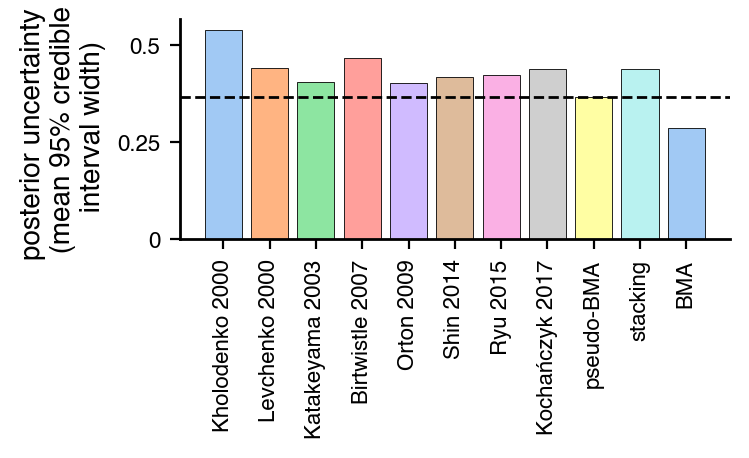

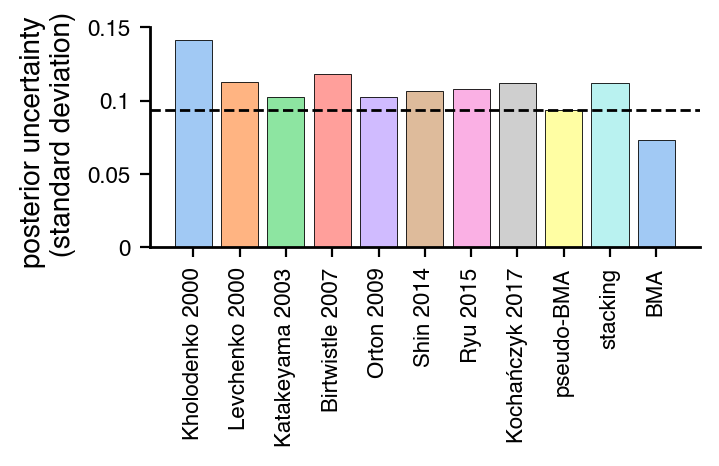

In [51]:
posterior_uncertainty_95 = []
for i, name in enumerate(model_names):
    posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(posterior_samples[i], [0.025, 0.975], axis=0), axis=0)))

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(loo_pbma_combined, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(loo_stack_combined, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(loo_bma_combined, [0.025, 0.975], axis=0), axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_95, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_95[-3]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (mean 95% credible \n interval width)', fontsize=10.0)
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels([0, 0.25, 0.5], fontsize=8.0)
fig.savefig('../../../results/MAPK/mmi/mapk_post_uncert_95.pdf', transparent=True)

posterior_uncertainty_std = []
for i, name in enumerate(model_names):
    posterior_uncertainty_std.append(np.mean(np.std(posterior_samples[i], axis=0)))

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_std.append(np.mean(np.std(loo_pbma_combined, axis=0)))
posterior_uncertainty_std.append(np.mean(np.std(loo_stack_combined, axis=0)))
posterior_uncertainty_std.append(np.mean(np.std(loo_bma_combined, axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_std, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_std[-3]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels([0, 0.05, 0.1, 0.15], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (standard deviation)', fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/mapk_post_uncert_std.pdf', transparent=True)